In [1]:
import xarray as xr
import pandas as pd
import seaborn as sns
from itertools import product
import matplotlib.pyplot as plt
import os, sys
USER = os.getenv('USER')
import numpy as np

In [2]:
# simulations = [1, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
# rff_sp = [1, 1000, 2000, 3000, 5000, 6000, 8000, 9000, 10000]
rff_sp = [ 988, 3623, 4889, 6706, 7457, 7533, 9278]
v=3

# RFF weights graph

In [3]:
weights = xr.open_zarr(
    f"/shares/gcp/integration/rff/damage_function_weights/damage_function_weights{v}.zarr",
    consolidated=True,
).sel(
    rff_sp=rff_sp
).to_dataframe().reset_index()

In [4]:
data = {}
for s,m in product(weights.ssp.unique(), weights.model.unique()):
    data[f"{s}_{m}"] = weights.loc[(weights.model == m) & (weights.ssp == s)]

/tmp/ipykernel_156873/2793497419.py:14: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'/mnt/CIL_integration/rff_diagnostics/v{v}/weights_diagnostics.png', bbox_to_inches='tight', dpi=300)


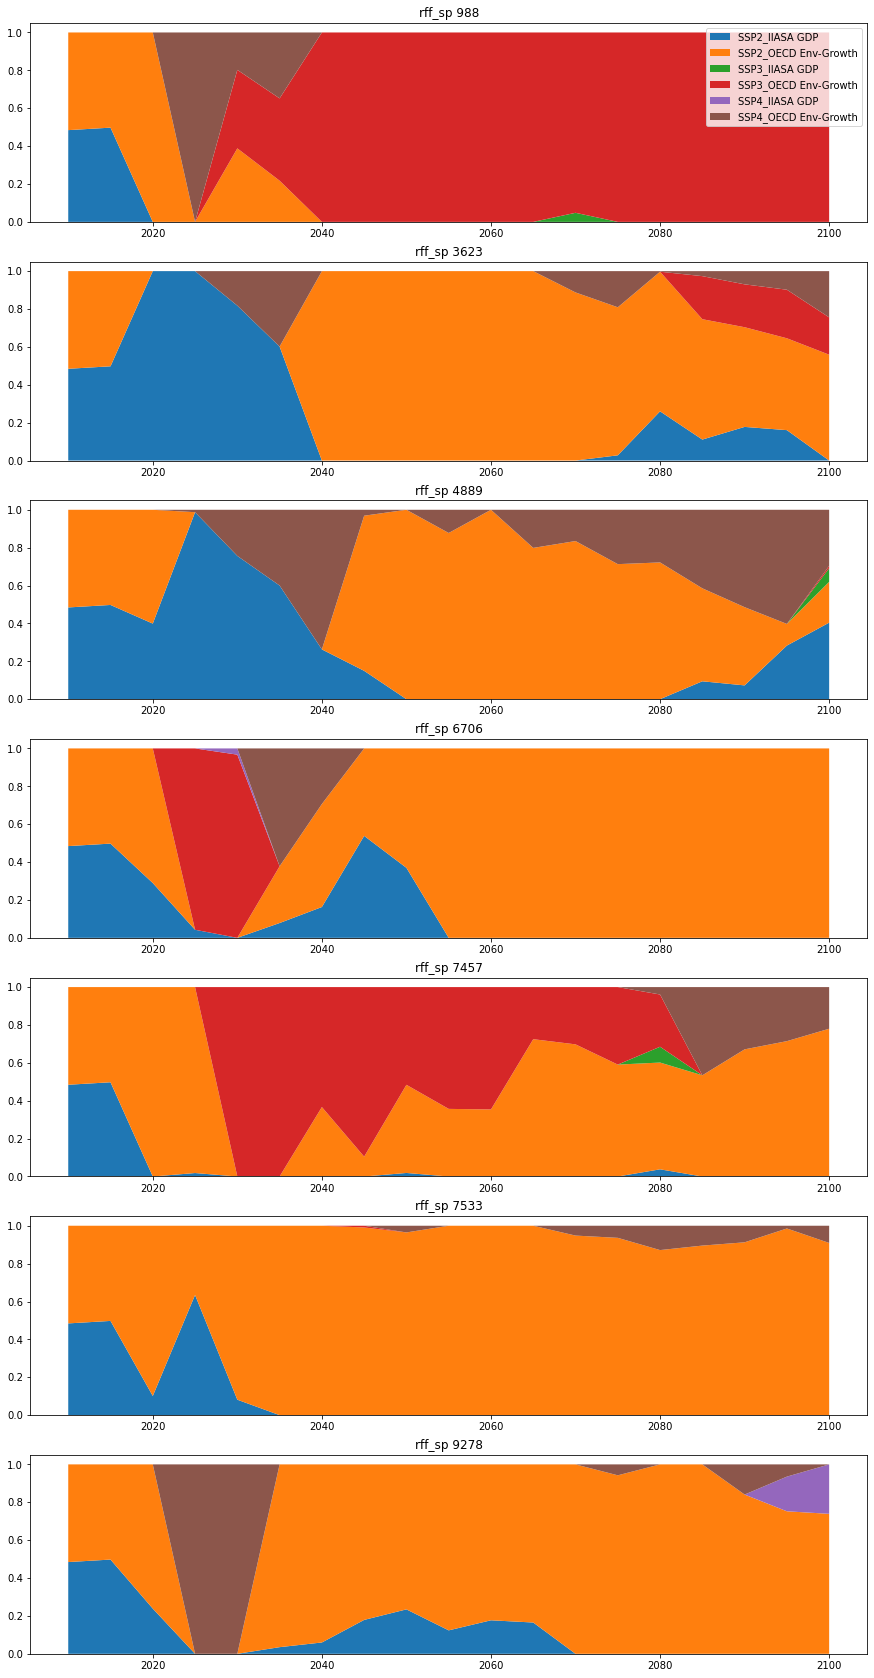

In [5]:
fig, ax = plt.subplots(len(rff_sp),1, figsize=(15,30))

for i, rff in enumerate(rff_sp):
    ax[i].stackplot(
        weights.year.unique(),
        *[j.loc[j.rff_sp == rff]['value'] for i,j in data.items()],
        labels=data.keys()
                 )
    
    ax[i].set_title(f"rff_sp {rff}")

ax[0].legend(loc='upper right')

plt.savefig(f'/mnt/CIL_integration/rff_diagnostics/v{v}/weights_diagnostics.png', bbox_to_inches='tight', dpi=300)

## Weighted damage functions

In [25]:
root = f"/home/{USER}/repos/integration/input_data/damage_function_library_rff{v}_rae_aggregated/"
sector = "AMEL_clipped"
recipes = ['adding_up', 'risk_aversion']
disc = 'constant'

/tmp/ipykernel_487015/3298821565.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'/mnt/CIL_integration/rff_diagnostics/v{v}/damage_functions/{sector}_{recipe}_{disc}.png', bbox_to_inches='tight', dpi=300)
/tmp/ipykernel_487015/3298821565.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'/mnt/CIL_integration/rff_diagnostics/v{v}/damage_functions/{sector}_{recipe}_{disc}.png', bbox_to_inches='tight', dpi=300)


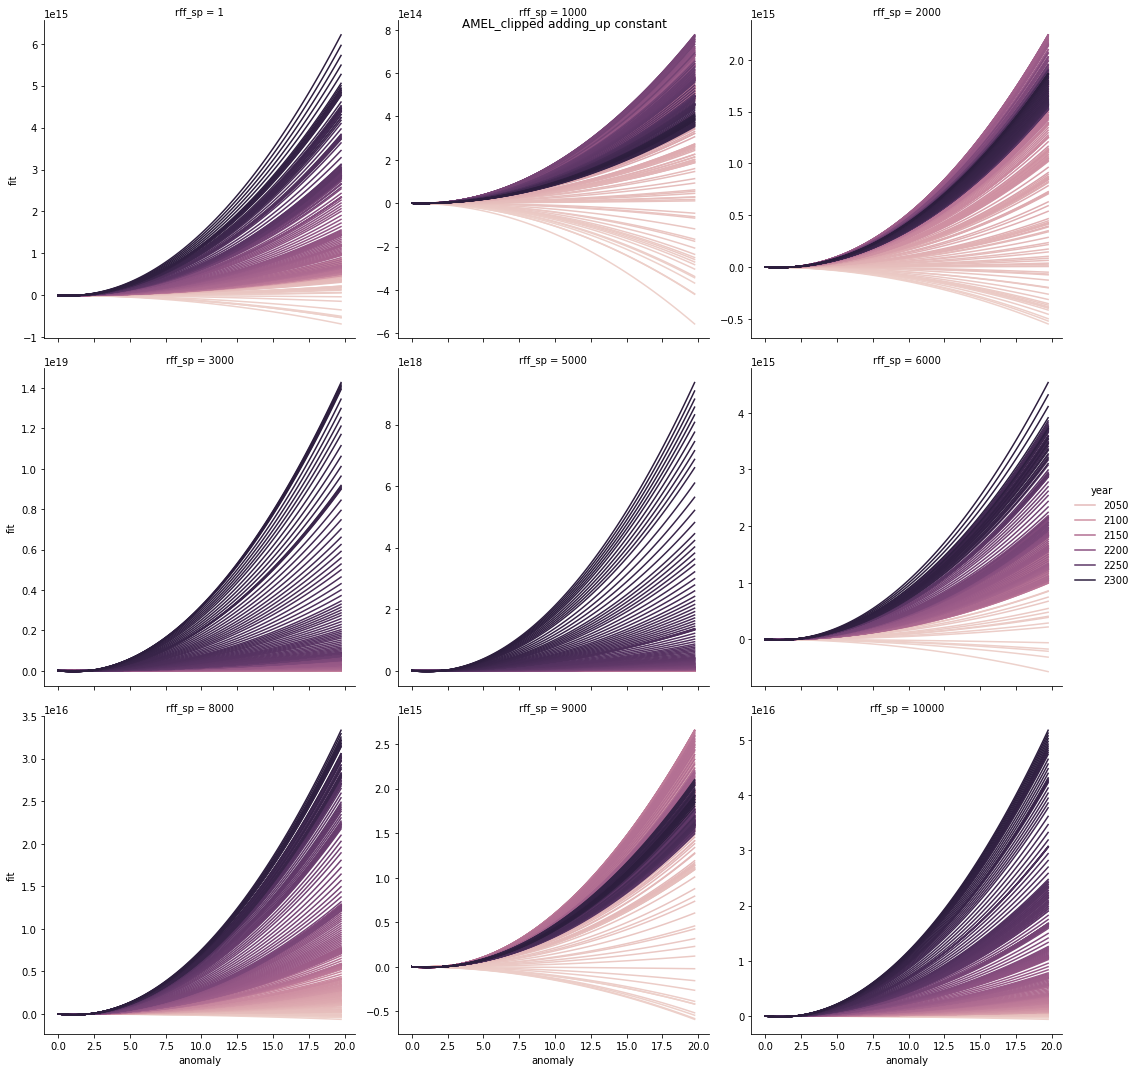

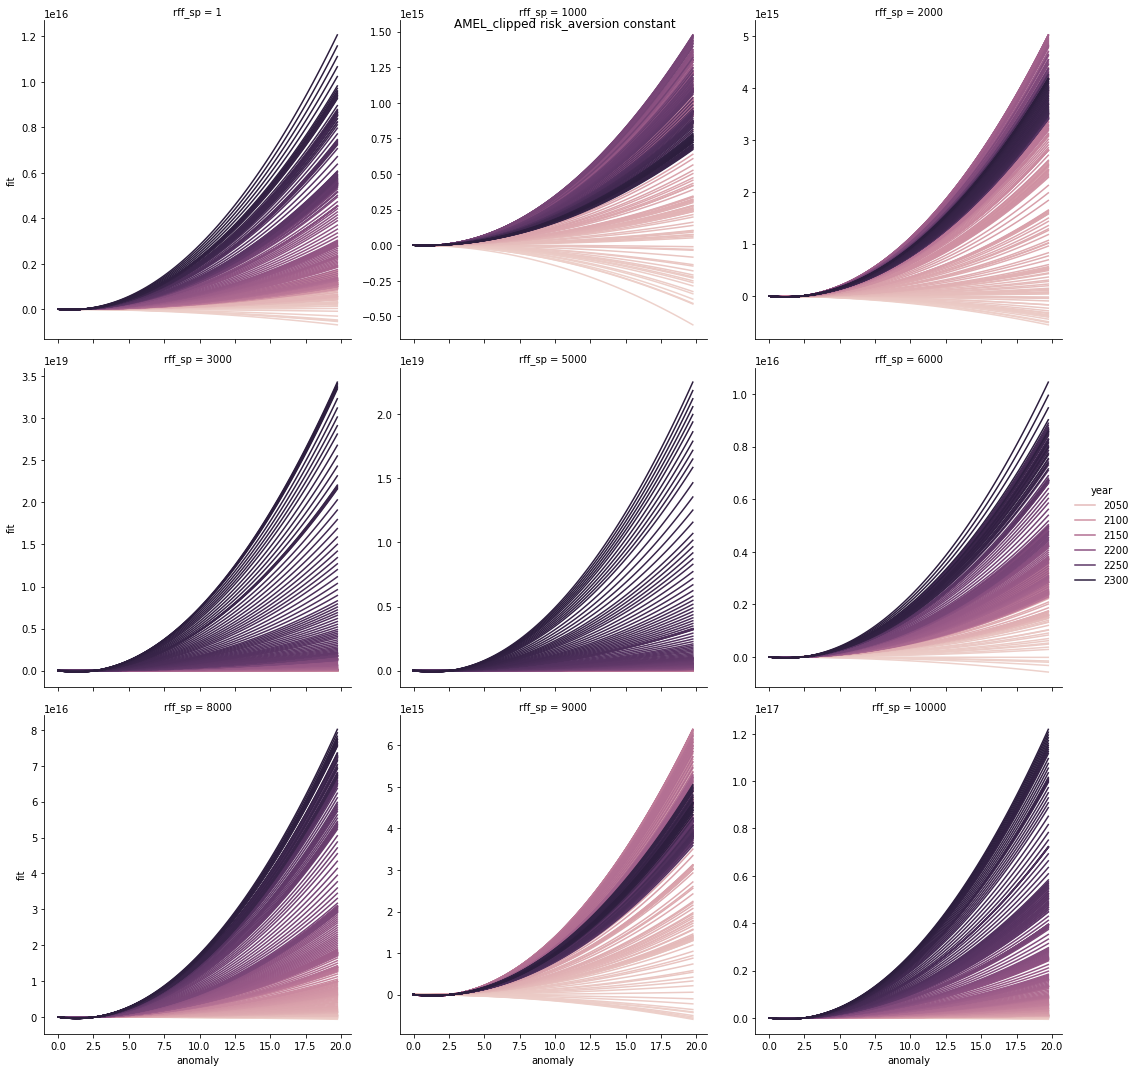

In [26]:
for recipe in recipes:

    ds = xr.open_dataset(f"{root}/{sector}/{recipe}_{disc}_eta2.0_rho0.0_damage_function_coefficients.nc4").sel(rff_sp=rff_sp)

    temps = xr.DataArray(
        np.arange(0,20, 0.25),
        coords={
            'anomaly' : np.arange(0,20, 0.25)
        })

    fit = ds['anomaly'] * temps + ds['np.power(anomaly, 2)'] * temps ** 2
    fit = fit.to_dataframe('fit').reset_index()

    g = sns.relplot(
        data=fit,
             x='anomaly',
             y='fit',
             hue='year',
             col='rff_sp',
             col_wrap=3,
             kind='line',
             facet_kws={'sharey': False, 'sharex': True}
            )

    g.fig.suptitle(f"{sector} {recipe} {disc}")

    plt.savefig(f'/mnt/CIL_integration/rff_diagnostics/v{v}/damage_functions/{sector}_{recipe}_{disc}.png', bbox_to_inches='tight', dpi=300)

# Emulated versus true GDP

In [27]:
weights = xr.open_zarr(
    f"/shares/gcp/integration/rff/damage_function_weights/damage_function_weights{v}.zarr",
    consolidated=True
).value

socioec = xr.open_zarr(
    "/shares/gcp/integration/float32/dscim_input_data/econvars/zarrs/integration-econ-bc39.zarr",
    consolidated=True
).gdp.sum('region')

emu = (weights * socioec).sum(['ssp', 'model']).expand_dims({'scenario' : ['emulated']})

true = xr.open_dataset(
    "/shares/gcp/integration/rff_rae/socioeconomics/rff_global_socioeconomics.nc4"
).gdp.sel(rff_sp=emu.rff_sp, region='world', drop=True).expand_dims({'scenario' : ['true']})

merged = xr.concat([emu, true], dim='scenario').sel(rff_sp=rff_sp).to_dataframe('gdp').reset_index()

/tmp/ipykernel_487015/1781112267.py:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'/mnt/CIL_integration/rff_diagnostics/v{v}/emulated_true_global_gdp.png', bbox_to_inches='tight', dpi=300)


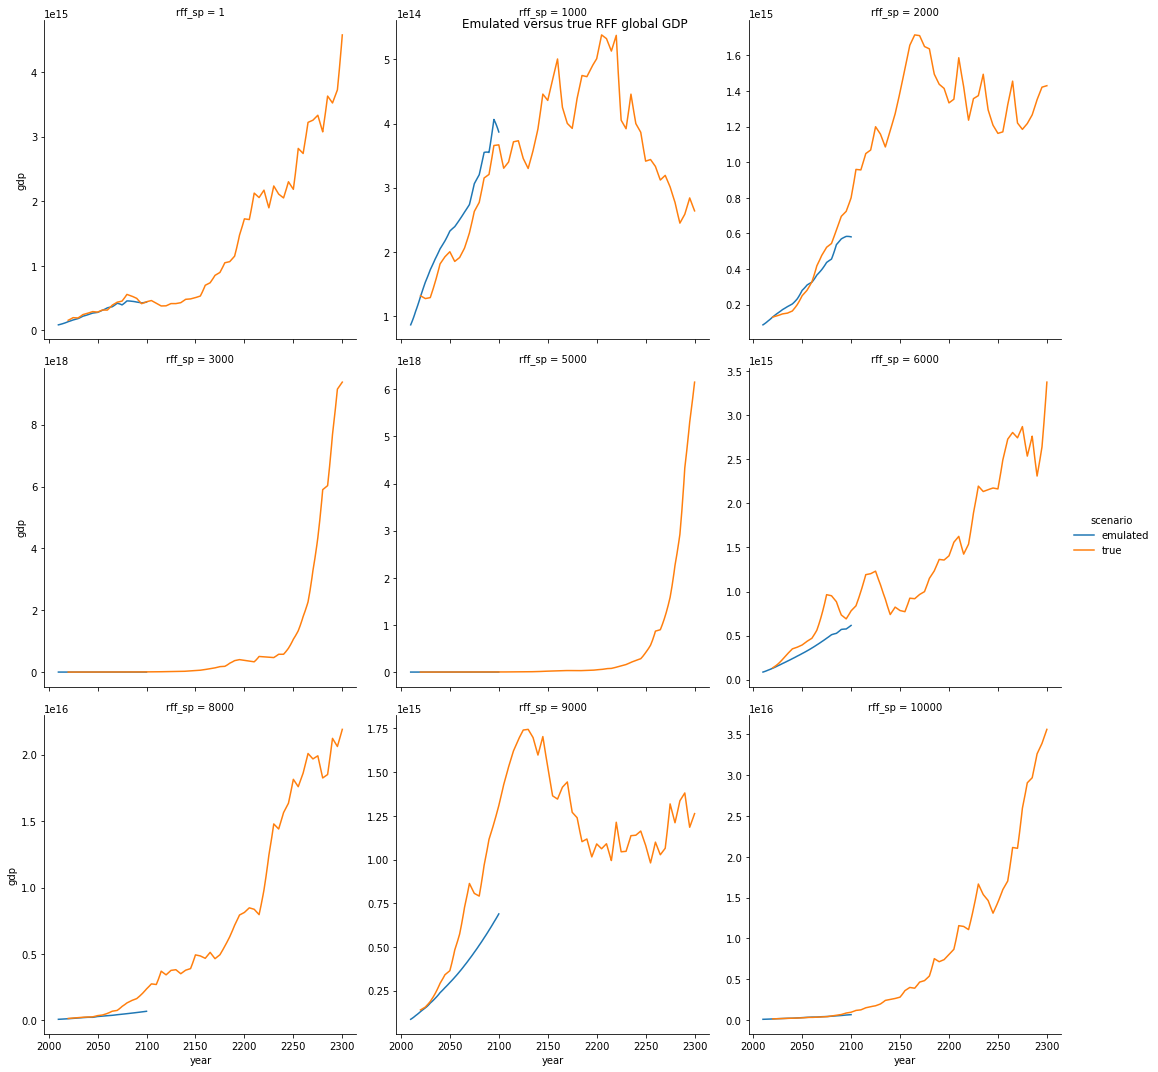

In [28]:
g = sns.relplot(data=merged, # .loc[merged.year.isin(range(2100))],
            x='year',
            y='gdp',
            hue='scenario',
            col='rff_sp',
            col_wrap=3,
            kind='line',
            facet_kws={'sharey': False, 'sharex': True}
           )

g.fig.suptitle(f"Emulated versus true RFF global GDP")

plt.savefig(f'/mnt/CIL_integration/rff_diagnostics/v{v}/emulated_true_global_gdp.png', bbox_to_inches='tight', dpi=300)

In [29]:
# plot RFF DF and SSP DF on the same plot
root_ssp = f"/home/{USER}/repos/integration/input_data/damage_function_library/"

In [49]:
recipe = "adding_up"

In [51]:
ds_ssp

<xarray.Dataset>
Dimensions:               (discount_type: 1, ssp: 3, model: 2, year: 281)
Coordinates:
  * discount_type         (discount_type) object 'constant'
  * model                 (model) object 'IIASA GDP' 'OECD Env-Growth'
  * ssp                   (ssp) object 'SSP2' 'SSP3' 'SSP4'
  * year                  (year) int64 2020 2021 2022 2023 ... 2298 2299 2300
Data variables:
    anomaly               (discount_type, ssp, model, year) float64 ...
    np.power(anomaly, 2)  (discount_type, ssp, model, year) float64 ...
Attributes: (12/53)
    sector_path:                    /shares/gcp/integration/float32/input_dat...
    save_path:                      /mnt/CIL_integration/menu_results_AR6_bc3...
    cons_clip:                      39.39265060424805
    subset_dict:                    {'ssp': ['SSP2', 'SSP3', 'SSP4']}
    econ_vars:                      <dscim.menu.simple_storage.EconVars objec...
    climate:                        <dscim.menu.simple_storage.Climate object...
    ...                             ...
    emission_scenarios:             ['ssp370', 'ssp245', 'ssp460']
    gases:                          ['CO2_Fossil']
    base_period:                    [2001, 2010]
    ecs_mask_path:                  /shares/gcp/integration/float32/dscim_inp...
    ecs_mask_name:                  None
    path:                           /shares/gcp/integration/float32/dscim_inp...

Text(0.5, 0.98, 'AMEL_clipped adding_up constant')

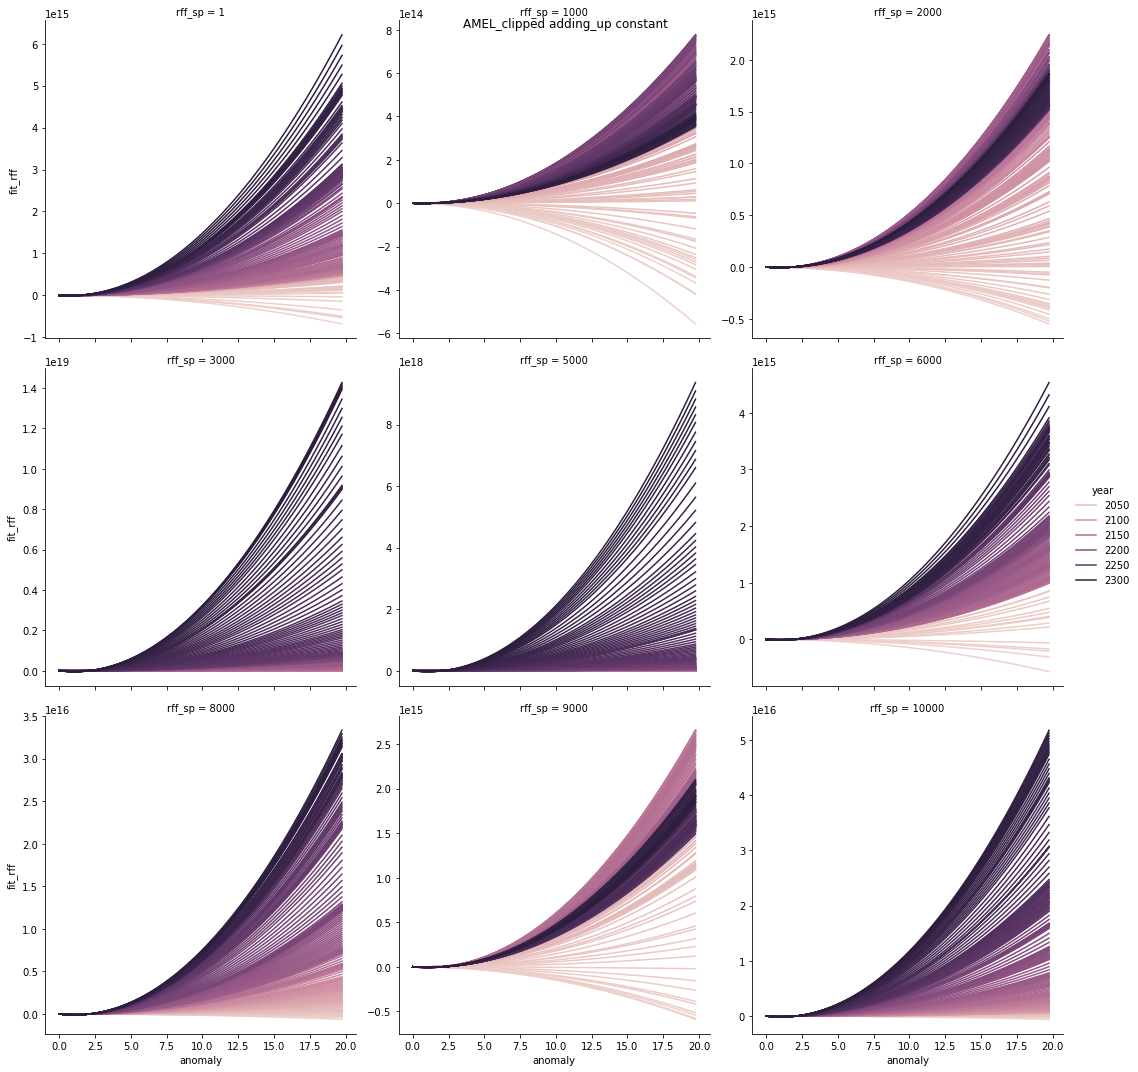

In [65]:
# for recipe in recipes:

ds_rff = xr.open_dataset(f"{root}/{sector}/{recipe}_{disc}_eta2.0_rho0.0_damage_function_coefficients.nc4").sel(rff_sp=rff_sp)
ds_ssp = xr.open_dataset(f"{root_ssp}/{sector}/{recipe}_{disc}_eta2.0_rho0.0_damage_function_coefficients.nc4")

temps = xr.DataArray(
    np.arange(0,20, 0.25),
    coords={
        'anomaly' : np.arange(0,20, 0.25)
    })

fit_rff = ds_rff['anomaly'] * temps + ds_rff['np.power(anomaly, 2)'] * temps ** 2
fit_rff = fit_rff.to_dataframe('fit_rff').reset_index()

fit_ssp = ds_ssp['anomaly'] * temps + ds_ssp['np.power(anomaly, 2)'] * temps ** 2
fit_ssp = fit_ssp.to_dataframe('fit_ssp').reset_index()
fit_ssp["ssp-model"] = fit_ssp.ssp + "-" + fit_ssp.model

g = sns.relplot(
    data=fit_rff,
         x='anomaly',
         y='fit_rff',
         hue='year',
         col='rff_sp',
         col_wrap=3,
         kind='line',
         facet_kws={'sharey': False, 'sharex': True}
        )

g.fig.suptitle(f"{sector} {recipe} {disc}")

#     plt.savefig(f'/mnt/CIL_integration/rff_diagnostics/v{v}/damage_functions/{sector}_{recipe}_{disc}.png', bbox_to_inches='tight', dpi=300)

In [66]:
ds_rff

<xarray.Dataset>
Dimensions:               (year: 281, discount_type: 1, rff_sp: 9)
Coordinates:
  * year                  (year) int64 2020 2021 2022 2023 ... 2298 2299 2300
  * discount_type         (discount_type) object 'constant'
  * rff_sp                (rff_sp) int64 1 1000 2000 3000 ... 8000 9000 10000
Data variables:
    anomaly               (discount_type, year, rff_sp) float64 ...
    np.power(anomaly, 2)  (discount_type, year, rff_sp) float64 ...

Text(0.5, 0.98, 'AMEL_clipped adding_up constant')

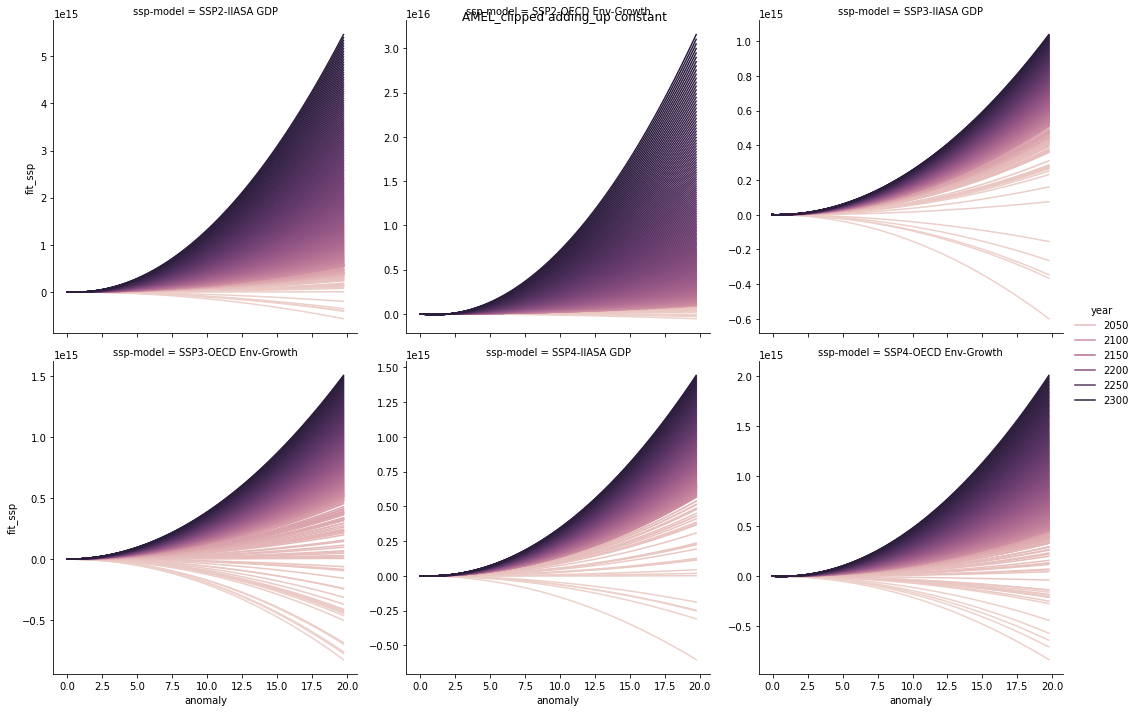

In [52]:

g = sns.relplot(
    data=fit_ssp,
         x='anomaly',
         y='fit_ssp',
         hue='year',
         col='ssp-model',
         col_wrap=3,
         kind='line',
         facet_kws={'sharey': False, 'sharex': True}
        )

g.fig.suptitle(f"{sector} {recipe} {disc}")

/home/liruixue/miniconda3/envs/dscim/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/liruixue/miniconda3/envs/dscim/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


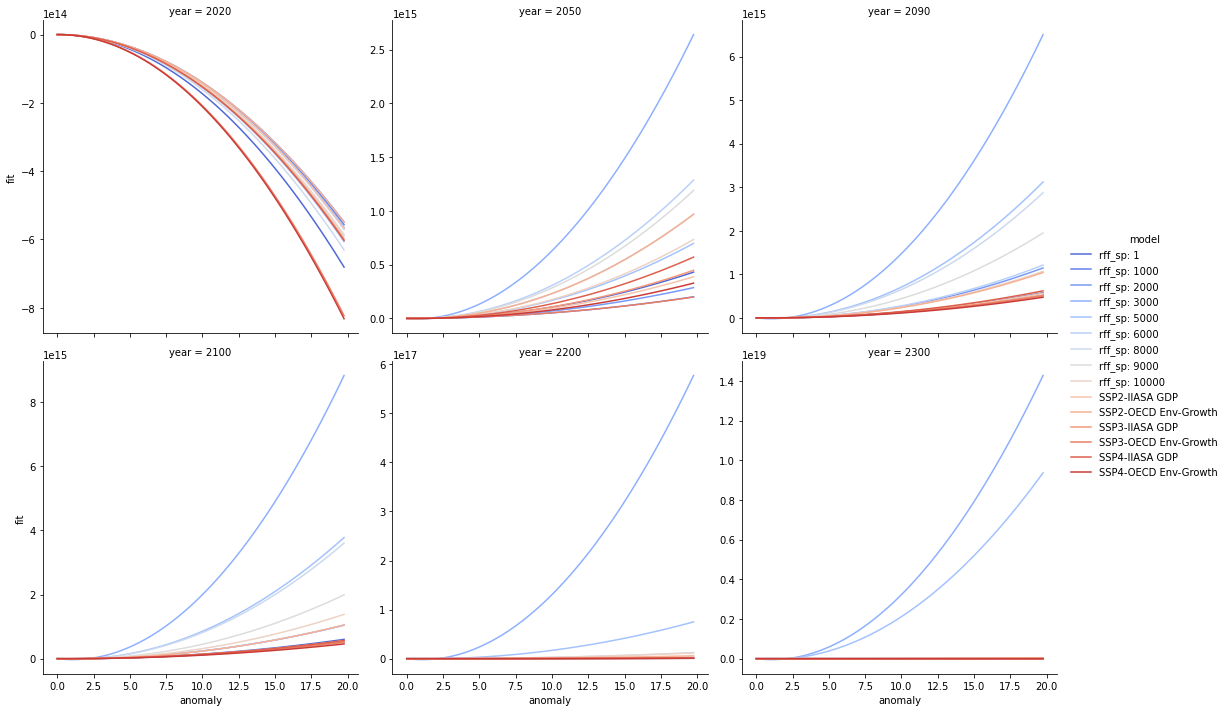

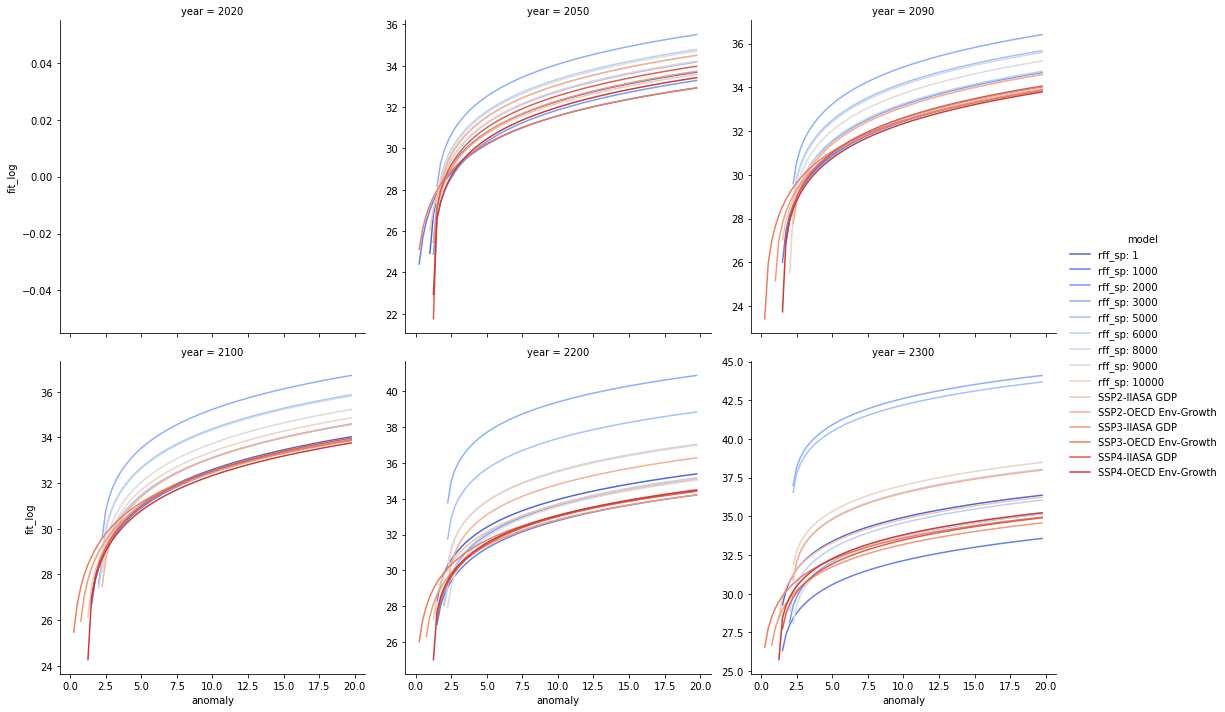

In [107]:
# overlap ssp and rff
years = [2020, 2050, 2090, 2100, 2200, 2300]
ds_rff = xr.open_dataset(f"{root}/{sector}/{recipe}_{disc}_eta2.0_rho0.0_damage_function_coefficients.nc4").sel(rff_sp=rff_sp, year = years)
ds_ssp = xr.open_dataset(f"{root_ssp}/{sector}/{recipe}_{disc}_eta2.0_rho0.0_damage_function_coefficients.nc4").sel(year = years)

temps = xr.DataArray(
    np.arange(0,20, 0.25),
    coords={
        'anomaly' : np.arange(0,20, 0.25)
    })

fit_rff = ds_rff['anomaly'] * temps + ds_rff['np.power(anomaly, 2)'] * temps ** 2
fit_rff = fit_rff.to_dataframe('fit').reset_index()
fit_rff['model'] =  "rff_sp: " + fit_rff['rff_sp'].astype(str)
fit_rff = fit_rff[['fit','year','model','anomaly']]

fit_ssp = ds_ssp['anomaly'] * temps + ds_ssp['np.power(anomaly, 2)'] * temps ** 2
fit_ssp = fit_ssp.to_dataframe('fit').reset_index()
fit_ssp["model"] = fit_ssp.ssp + "-" + fit_ssp.model
fit_ssp = fit_ssp[['fit','year','model','anomaly']]

fit = pd.concat([fit_rff, fit_ssp]).set_index(['year','model','anomaly'])
fit['fit_log'] = np.log(fit['fit'])
g = sns.relplot(
    data=fit,
         x='anomaly',
         y='fit',
         hue='model',
         col='year',
         col_wrap=3,
         kind='line',
         palette = 'coolwarm',
         facet_kws={'sharey': False, 'sharex': True}
        )

g = sns.relplot(
    data=fit,
         x='anomaly',
         y='fit_log',
         hue='model',
         col='year',
         col_wrap=3,
         kind='line',
         palette = 'coolwarm',
         facet_kws={'sharey': False, 'sharex': True}
        )

# g.fig.suptitle(f"{sector} {recipe} {disc}")

#     plt.savefig(f'/mnt/CIL_integration/rff_diagnostics/v{v}/damage_functions/{sector}_{recipe}_{disc}.png', bbox_to_inches='tight', dpi=300)

In [108]:
fit

fit    fit_log
year model                anomaly                         
2020 rff_sp: 1            0.00     0.000000e+00       -inf
                          0.25    -5.193930e+10        NaN
                          0.50    -3.235846e+11        NaN
                          0.75    -8.149359e+11        NaN
                          1.00    -1.525993e+12        NaN
...                                         ...        ...
2300 SSP4-OECD Env-Growth 18.75    1.798820e+15  35.125907
                          19.00    1.848811e+15  35.153319
                          19.25    1.899487e+15  35.180360
                          19.50    1.950848e+15  35.207040
                          19.75    2.002892e+15  35.233369

[7200 rows x 2 columns]

In [76]:
fit_ssp

,discount_type,ssp,model,year,anomaly,fit_ssp,ssp-model
0,constant,SSP2,IIASA GDP,2020,0.00,0.000000e+00,SSP2-IIASA GDP
1,constant,SSP2,IIASA GDP,2020,0.25,-4.589979e+10,SSP2-IIASA GDP
2,constant,SSP2,IIASA GDP,2020,0.50,-2.749981e+11,SSP2-IIASA GDP
3,constant,SSP2,IIASA GDP,2020,0.75,-6.872950e+11,SSP2-IIASA GDP
4,constant,SSP2,IIASA GDP,2020,1.00,-1.282790e+12,SSP2-IIASA GDP
...,...,...,...,...,...,...,...
2875,constant,SSP4,OECD Env-Growth,2300,18.75,1.798820e+15,SSP4-OECD Env-Growth
2876,constant,SSP4,OECD Env-Growth,2300,19.00,1.848811e+15,SSP4-OECD Env-Growth
2877,constant,SSP4,OECD Env-Growth,2300,19.25,1.899487e+15,SSP4-OECD Env-Growth
2878,constant,SSP4,OECD Env-Growth,2300,19.50,1.950848e+15,SSP4-OECD Env-Growth
